Файл [diamonds.scv](https://drive.google.com/file/d/1FcyqCTFwKKtK9-YAeTBWKpLD8LCAdvWp/view?usp=sharing) содержит данные о ценах и других аттрибутах более чем 54000 алмазов. В колонках перечислены следующие аттрибуты:

*   price - price in US dollars
*   carat - weight of the diamond
*   cut - quality of the cut (Fair, Good, Very Good, Premium, Ideal)
*   color - diamond colour, from J (worst) to D (best)
*   clarity - a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
*   x - length in mm (0--10.74)
*   y - width in mm (0--58.9)
*   z - depth in mm (0--31.8)
*   depth - total depth percentage
*   table - width of top of diamond relative to widest point (43--95)

1. Загрузить данные.

In [ ]:
import numpy as np
import pandas as pd
import sklearn.linear_model as skl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

df = pd.read_csv('diamonds.csv')
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


2. В данных присутствуют нечисловые переменные, поэтому следует провести, так называемое, кодирование, т.е. переход от словесного описания данных к числовому. В данной задаче удобно использовать ранговое кодирование. Перед кодированием рекомендуется скопировать старый датафрейм в новую переменную. Пример кода приведен ниже:

In [ ]:
#старый датафрейм копируется в новую переменную df_new
df_new = df.copy()

In [ ]:
# пример рангового кодирования для колонки 'cut'
df_new = df_new.replace({'cut': {'Fair'     :1,
                                   'Good'     :2,
                                   'Very Good':3,
                                   'Premium'  :4,
                                   'Ideal'    :5
                                   }
                          })

/tmp/ipython-input-2475898661.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_new = df_new.replace({'cut': {'Fair'     :1,


В таком же стиле следует закодировать все нечисловые данные.

In [ ]:
df['color'].unique()

array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object)

In [ ]:
df['clarity'].unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
      dtype=object)

In [ ]:
df_new = df_new.replace({'color': {
    'J': 1,
    'I': 2,
    'H': 3,
    'G': 4,
    'F': 5,
    'E': 6,
    'D': 7
}})

/tmp/ipython-input-2296938161.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_new = df_new.replace({'color': {


In [ ]:
df_new = df_new.replace({'clarity': {
    'I1': 1,     # Худшая
    'SI2': 2,
    'SI1': 3,
    'VS2': 4,
    'VS1': 5,
    'VVS2': 6,
    'VVS1': 7,
    'IF': 8      # Лучшая
}})

/tmp/ipython-input-131087237.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_new = df_new.replace({'clarity': {


In [ ]:
df_new.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,5,6,2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,4,6,3,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,2,6,5,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,4,2,4,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,2,1,2,63.3,58.0,335,4.34,4.35,2.75


3. Провести предварительные обзор данных: нарисовать не менее 4-х графиков зависимости одних признаков от других; вывести результаты метода describe(), info().

In [ ]:
df_new.describe()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,3.904097,4.405803,4.051020,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.116600,1.701105,1.647136,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,1.000000,1.000000,1.000000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,3.000000,3.000000,3.000000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,4.000000,4.000000,4.000000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,5.000000,6.000000,5.000000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,5.000000,7.000000,8.000000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  int64  
 3   color       53940 non-null  int64  
 4   clarity     53940 non-null  int64  
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 4.5 MB


/tmp/ipython-input-3685147996.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_new[df_new['cut'] == i]['price'] for i in cut_values], labels=cut_names)
/tmp/ipython-input-3685147996.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_new[df_new['color'] == i]['price'] for i in color_values], labels=color_names)
/tmp/ipython-input-3685147996.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_new[df_new['clarity'] == i]['price'] for i in clarity_values], labels=clarity_names)


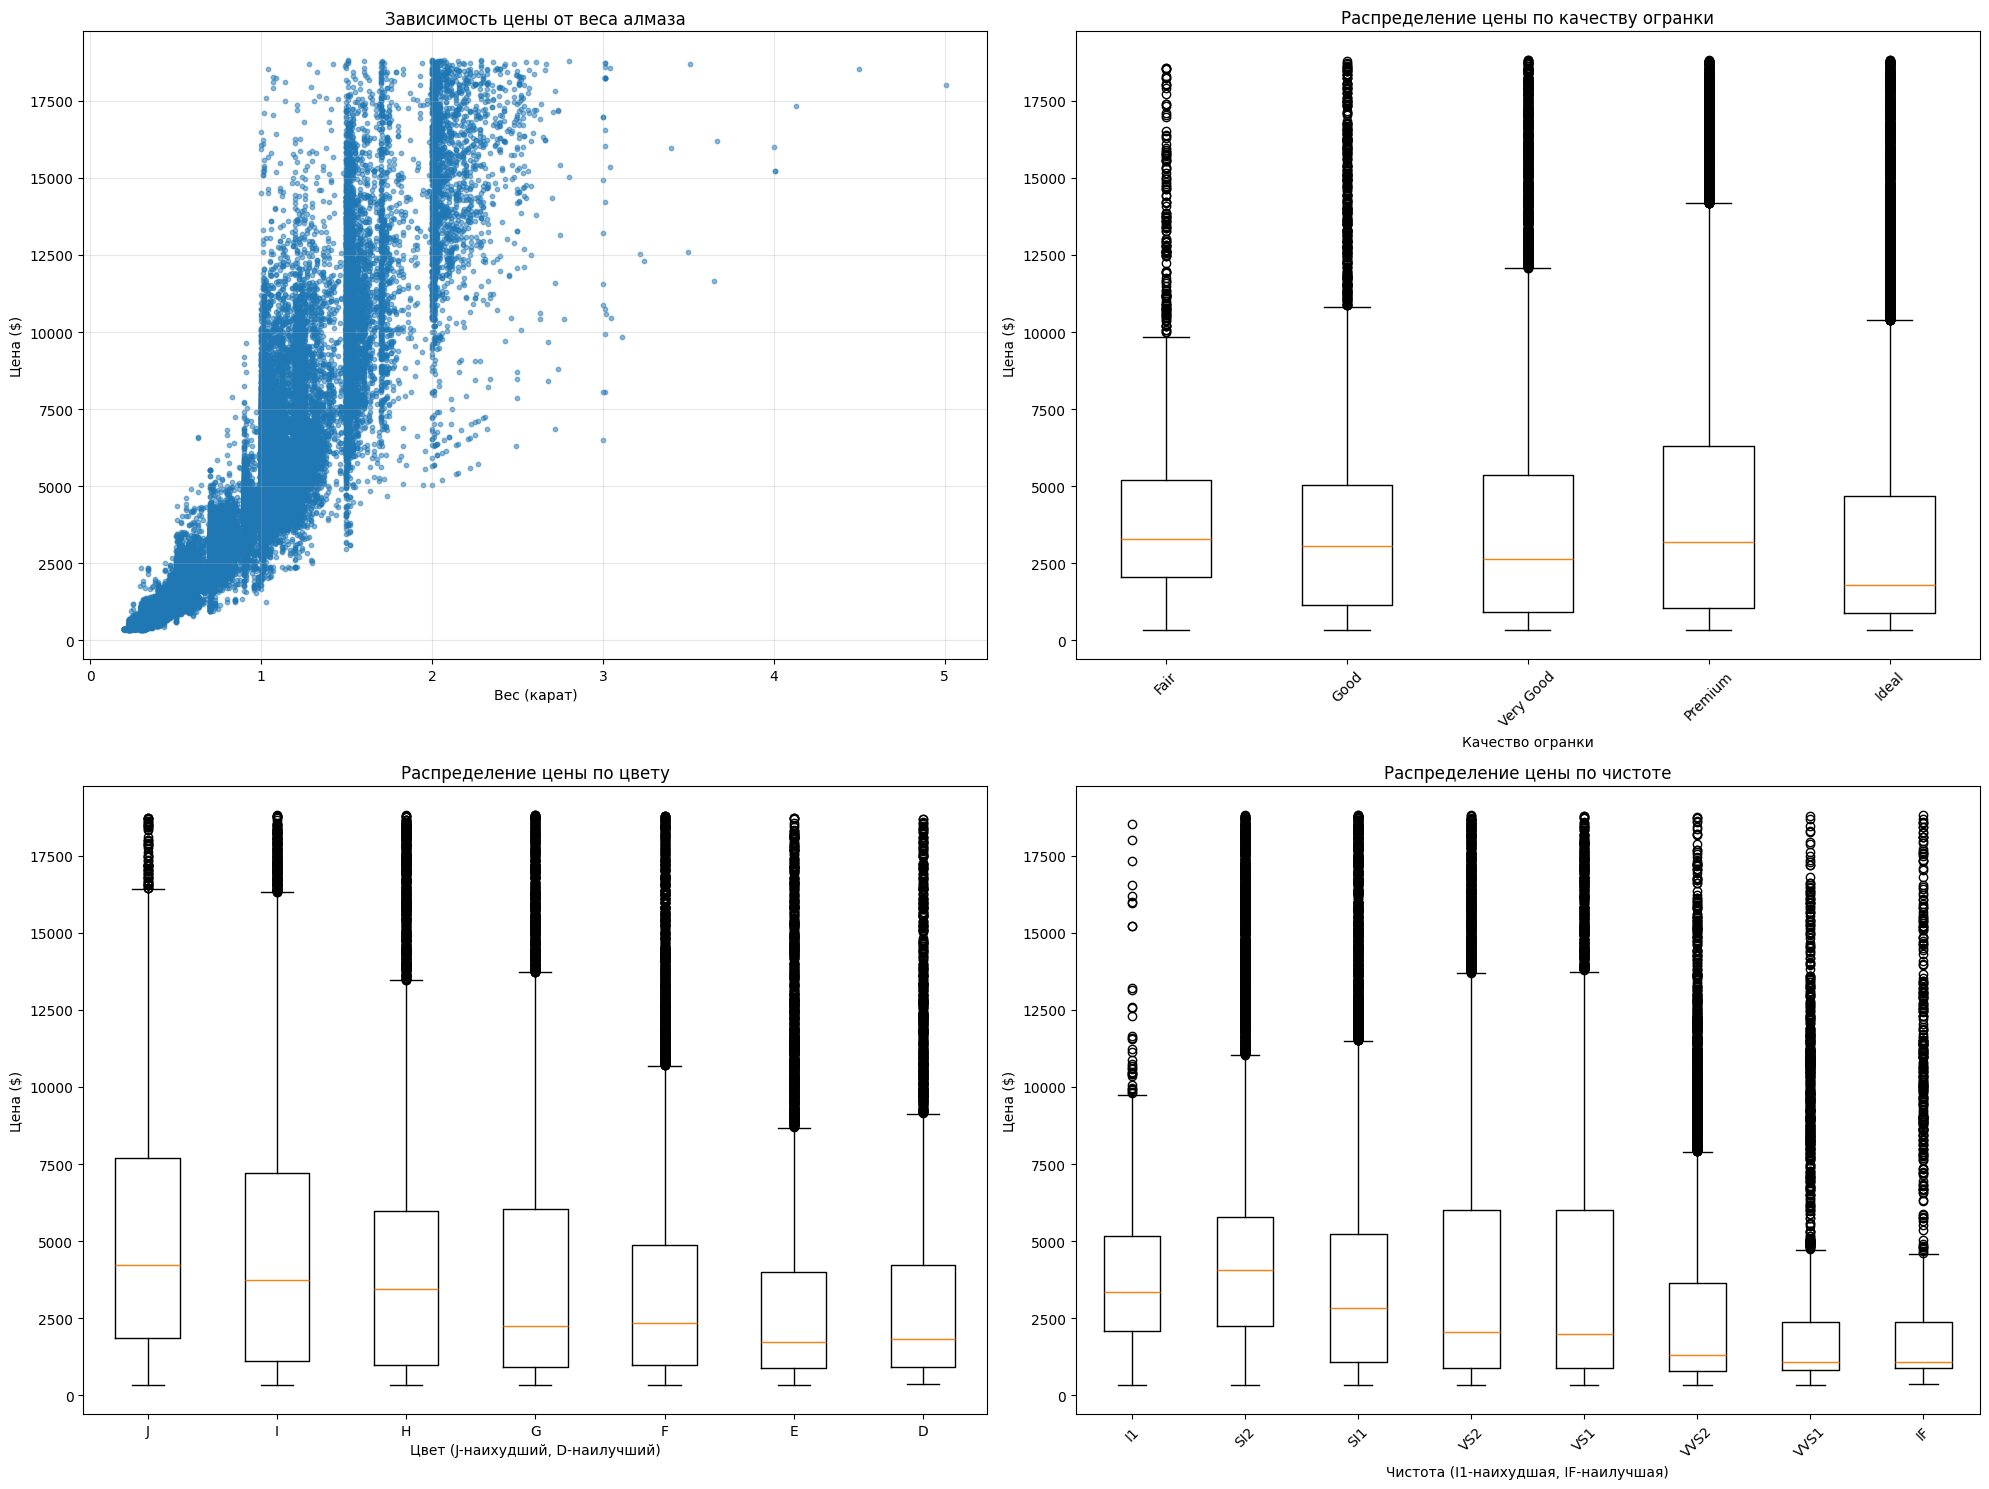

In [ ]:
plt.figure(figsize=(20, 15))

# График 1: Зависимость цены от веса (carat)
plt.subplot(2, 2, 1)
plt.scatter(df_new['carat'], df_new['price'], alpha=0.5, s=10)
plt.xlabel('Вес (карат)')
plt.ylabel('Цена ($)')
plt.title('Зависимость цены от веса алмаза')
plt.grid(True, alpha=0.3)

# График 2: Зависимость цены от качества огранки
plt.subplot(2, 2, 2)
cut_names = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
cut_values = [1, 2, 3, 4, 5]
plt.boxplot([df_new[df_new['cut'] == i]['price'] for i in cut_values], labels=cut_names)
plt.xlabel('Качество огранки')
plt.ylabel('Цена ($)')
plt.title('Распределение цены по качеству огранки')
plt.xticks(rotation=45)

# График 3: Зависимость цены от цвета
plt.subplot(2, 2, 3)
color_names = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
color_values = [1, 2, 3, 4, 5, 6, 7]
plt.boxplot([df_new[df_new['color'] == i]['price'] for i in color_values], labels=color_names)
plt.xlabel('Цвет (J-наихудший, D-наилучший)')
plt.ylabel('Цена ($)')
plt.title('Распределение цены по цвету')

# График 4: Зависимость цены от чистоты
plt.subplot(2, 2, 4)
clarity_names = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
clarity_values = [1, 2, 3, 4, 5, 6, 7, 8]
plt.boxplot([df_new[df_new['clarity'] == i]['price'] for i in clarity_values], labels=clarity_names)
plt.xlabel('Чистота (I1-наихудшая, IF-наилучшая)')
plt.ylabel('Цена ($)')
plt.title('Распределение цены по чистоте')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

4. Построить регрессионную модель, которая предсказывает цену алмаза в зависимости от остальных его характеристик.

*   а) простая линейная модель
*   б) линейная модель с l1-регуляризацией
*   в) линейная модель с l2-регуляризацией
*   г) полиномиальная модель

В качестве метрик использовать функции mae, mse, $r^2$. Обязательно делать разбивку на тестовую и обучающую выборки.

In [ ]:
# Удаляем первый столбец (индекс)
df_encoded = df_encoded.drop(df_encoded.columns[0], axis=1)

# Разделение на признаки и целевую переменную
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Размеры выборок:")
print(f"Обучающая: {X_train.shape}")
print(f"Тестовая: {X_test.shape}")

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Словарь для хранения результатов
results = {}

# а) Простая линейная регрессия
print("\n" + "="*50)
print("а) ПРОСТАЯ ЛИНЕЙНАЯ РЕГРЕССИЯ")
print("="*50)

linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Предсказания
y_pred_linear = linear_model.predict(X_test_scaled)

# Метрики
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

results['Linear'] = {'MAE': mae_linear, 'MSE': mse_linear, 'R2': r2_linear}

print(f"MAE: {mae_linear:.2f}")
print(f"MSE: {mse_linear:.2f}")
print(f"R²: {r2_linear:.4f}")

# б) Линейная модель с L1-регуляризацией (Lasso)
print("\n" + "="*50)
print("б) LASSO РЕГРЕССИЯ (L1-регуляризация)")
print("="*50)

# Подбор оптимального alpha с помощью кросс-валидации
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
best_alpha_l1 = 0.1
best_score_l1 = -np.inf

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    lasso_model.fit(X_train_scaled, y_train)
    score = lasso_model.score(X_test_scaled, y_test)
    if score > best_score_l1:
        best_score_l1 = score
        best_alpha_l1 = alpha

lasso_model = Lasso(alpha=best_alpha_l1, random_state=42, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)

y_pred_lasso = lasso_model.predict(X_test_scaled)

mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

results['Lasso'] = {'MAE': mae_lasso, 'MSE': mse_lasso, 'R2': r2_lasso}

print(f"Лучший alpha: {best_alpha_l1}")
print(f"MAE: {mae_lasso:.2f}")
print(f"MSE: {mse_lasso:.2f}")
print(f"R²: {r2_lasso:.4f}")

# в) Линейная модель с L2-регуляризацией (Ridge)
print("\n" + "="*50)
print("в) RIDGE РЕГРЕССИЯ (L2-регуляризация)")
print("="*50)

# Подбор оптимального alpha
best_alpha_l2 = 1
best_score_l2 = -np.inf

for alpha in alphas:
    ridge_model = Ridge(alpha=alpha, random_state=42, max_iter=10000)
    ridge_model.fit(X_train_scaled, y_train)
    score = ridge_model.score(X_test_scaled, y_test)
    if score > best_score_l2:
        best_score_l2 = score
        best_alpha_l2 = alpha

ridge_model = Ridge(alpha=best_alpha_l2, random_state=42, max_iter=10000)
ridge_model.fit(X_train_scaled, y_train)

y_pred_ridge = ridge_model.predict(X_test_scaled)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

results['Ridge'] = {'MAE': mae_ridge, 'MSE': mse_ridge, 'R2': r2_ridge}

print(f"Лучший alpha: {best_alpha_l2}")
print(f"MAE: {mae_ridge:.2f}")
print(f"MSE: {mse_ridge:.2f}")
print(f"R²: {r2_ridge:.4f}")

# г) Полиномиальная регрессия
print("\n" + "="*50)
print("г) ПОЛИНОМИАЛЬНАЯ РЕГРЕССИЯ")
print("="*50)

# Тестируем разные степени полинома
degrees = [2, 3]
best_degree = 2
best_score_poly = -np.inf

for degree in degrees:
    poly_model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('linear', LinearRegression())
    ])

    poly_model.fit(X_train, y_train)
    y_pred_poly = poly_model.predict(X_test)
    score = r2_score(y_test, y_pred_poly)

    if score > best_score_poly:
        best_score_poly = score
        best_degree = degree

# Лучшая полиномиальная модель
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', StandardScaler()),
    ('linear', LinearRegression())
])

poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)

mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

results['Polynomial'] = {'MAE': mae_poly, 'MSE': mse_poly, 'R2': r2_poly}

print(f"Лучшая степень полинома: {best_degree}")
print(f"MAE: {mae_poly:.2f}")
print(f"MSE: {mse_poly:.2f}")
print(f"R²: {r2_poly:.4f}")

# Сравнение моделей
print("\n" + "="*60)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*60)

comparison_df = pd.DataFrame(results).T
print(comparison_df.round(4))


# Вывод лучшей модели
print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"R²: {results[best_model_name]['R2']:.4f}")
print(f"MAE: {results[best_model_name]['MAE']:.2f}")
print(f"MSE: {results[best_model_name]['MSE']:.2f}")

# Коэффициенты моделей (для интерпретации)
print("\n" + "="*50)
print("КОЭФФИЦИЕНТЫ ЛИНЕЙНОЙ МОДЕЛИ")
print("="*50)
feature_names = X.columns
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': linear_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)
print(coefficients.head(10))

Размеры выборок:
Обучающая: (43152, 7)
Тестовая: (10788, 7)

а) ПРОСТАЯ ЛИНЕЙНАЯ РЕГРЕССИЯ
MAE: 1230.38
MSE: 2639666.98
R²: 0.8340

б) LASSO РЕГРЕССИЯ (L1-регуляризация)
Лучший alpha: 10
MAE: 1227.56
MSE: 2639352.62
R²: 0.8340

в) RIDGE РЕГРЕССИЯ (L2-регуляризация)
Лучший alpha: 100
MAE: 1228.47
MSE: 2637066.51
R²: 0.8341

г) ПОЛИНОМИАЛЬНАЯ РЕГРЕССИЯ
Лучшая степень полинома: 3
MAE: 389.57
MSE: 505711.22
R²: 0.9682

СРАВНЕНИЕ МОДЕЛЕЙ
                  MAE           MSE      R2
Linear      1230.3824  2.639667e+06  0.8340
Lasso       1227.5643  2.639353e+06  0.8340
Ridge       1228.4694  2.637067e+06  0.8341
Polynomial   389.5697  5.057112e+05  0.9682

ЛУЧШАЯ МОДЕЛЬ: Polynomial
R²: 0.9682
MAE: 389.57
MSE: 505711.22

КОЭФФИЦИЕНТЫ ЛИНЕЙНОЙ МОДЕЛИ
   Feature  Coefficient
4        x  3844.182724
1  clarity   901.152118
0    color   419.371031
5        y   165.460304
2    depth   122.367832
3    table   -87.885982
6        z    -9.911764
